## Generating composites based on events
This notebook works through an example where 'infill' composites are created either side of a temporal event. This can be useful for generating composite images which contain the most recent data prior-to and post event date (e.g. a fire).

In [27]:
%matplotlib inline

import datacube
from datacube.utils import cog
import matplotlib.pyplot as plt
import xarray as xr

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard, first, last, nearest
from dea_tools.bandindices import calculate_indices
from dea_tools.plotting import rgb

In [2]:
# Connect to the datacube
dc = datacube.Datacube(app='Infill_composites')

In [3]:
# Create a reusable query (can change resolution and/or bands here if needed)
query = {
    "lat": (-41.666, -41.525),
    "lon": (147.767, 147.984),
    "time": ("2019-06", "2020-06"),  # 12 months either side of event
    "measurements": [
        "nbart_blue",
        "nbart_green",
        "nbart_red",
        "nbart_nir_1",
        "nbart_swir_3",
    ],  # Can add nbart_swir_2 for true flase colour but change res to 20
    "output_crs": "EPSG:3577",
    "resolution": (-20, 20),
    "group_by": "solar_day",
}

In [4]:
# Load available data (try min_gooddata to limit clouds)
ds = load_ard(
    dc=dc,
    products=["s2a_ard_granule", "s2b_ard_granule"],
    #dask_chunks={"x": 2000, "y": 2000},
    min_gooddata=0.1, #looking for good data will increase compute time
    **query
)

# Print output data
ds

Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step


CPLReleaseMutex: Error = 1 (Operation not permitted)


Filtering to 41 out of 75 time steps with at least 10.0% good quality pixels
Applying pixel quality/cloud mask
Loading 41 time steps


<xarray.Dataset>
Dimensions:       (time: 41, y: 874, x: 1015)
Coordinates:
  * time          (time) datetime64[ns] 2019-06-04T00:08:18.851173 ... 2020-0...
  * y             (y) float64 -4.623e+06 -4.623e+06 ... -4.641e+06 -4.641e+06
  * x             (x) float64 1.341e+06 1.341e+06 ... 1.362e+06 1.362e+06
    spatial_ref   int32 3577
Data variables:
    nbart_blue    (time, y, x) float32 nan nan nan 15.0 ... 232.0 221.0 297.0
    nbart_green   (time, y, x) float32 nan nan nan 93.0 ... 288.0 281.0 322.0
    nbart_red     (time, y, x) float32 nan nan nan 177.0 ... 379.0 426.0 483.0
    nbart_nir_1   (time, y, x) float32 nan nan nan ... 943.0 824.0 981.0
    nbart_swir_3  (time, y, x) float32 238.0 197.0 171.0 ... 837.0 907.0 915.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

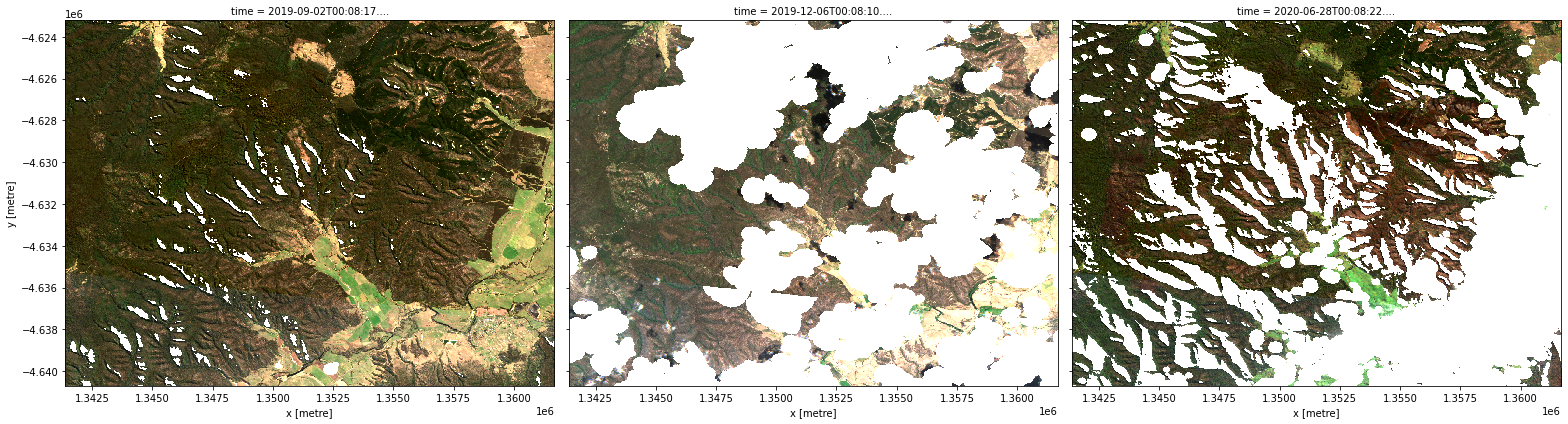

In [5]:
# Set the timesteps to visualise
timesteps = [10, 22, 40]

# Generate RGB plots at each timestep
rgb(ds, index=timesteps)

## Nearest-time composites¶
To get an image at a certain time, often there is missing data, due to clouds and other masking. We can fill in these gaps by using data from surrounding times.

To generate these images, we can use the custom functions first, last and nearest from the dea_datahandling script.

You can also use the in-built .first() and .last() methods when doing groupby and resample as described above. They are described in the xarray documentation on grouped data.

## Most-recent composite¶
Sometime we may want to determine what the landscape looks like by examining the most recent image. If we look at the last image for our dataset, we can see there is lots of missing data in the last image.

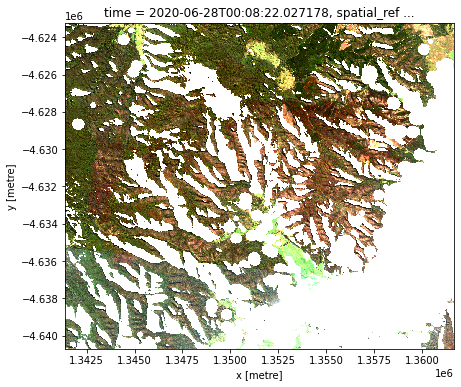

In [6]:
# Plot the last image in time
rgb(ds, index=-1)

We can calculate how much of the data is missing in this most recent image

In [7]:
last_blue_image = ds.nbart_blue.isel(time=-1)

precent_valid_data = float(last_blue_image.count() /
                           last_blue_image.size) * 100
print(f'The last image contains {precent_valid_data:.2f}% data.')

The last image contains 56.64% data.


In order to fill in the gaps and produce a complete image showing the most-recent satellite acquistion for every pixel, we can run the last function on one of the arrays. This will return the most recent cloud-free value that was observed by the satellite for every pixel in our dataset.

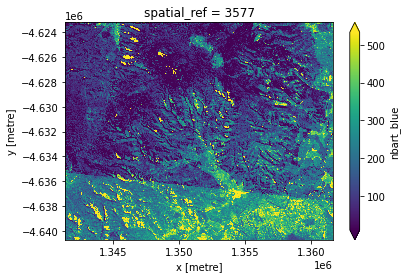

In [8]:
last_blue = last(ds.nbart_blue, dim='time')
last_blue.plot(robust=True);

To see how recent each pixel is, we can compare the age of the pixels with the latest value we have.

Here we can see that most pixels were from the last few time slices, although there are some that were much older.

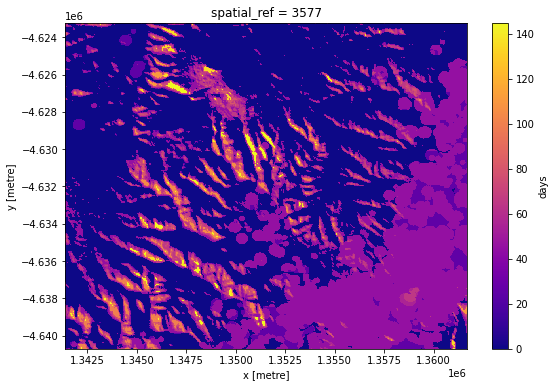

In [9]:
# Identify latest time in our data
last_time = last_blue.time.max()

# Compare the timestamps and convert them to number of days for plotting.
num_days_old = (last_time - last_blue.time).dt.days
num_days_old.plot(cmap='plasma', size=6);

In [15]:
last_time

<xarray.DataArray 'time' ()>
array('2020-06-28T00:08:22.027178000', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 3577

We can run this method on all of the bands. However we only want pixels that have data in every band. On the edges of a satellite pass, some bands don’t have data.

To get rid of pixels with missing data, we will convert the dataset to an array, and select only those pixels with data in all bands.

In [10]:
# Convert to array
da = ds.to_array(dim='variable')

# Create a mask where data has no-data
no_data_mask = da.isnull().any(dim='variable')

# Mask out regions where there is no-data
da = da.where(~no_data_mask)

## Before and after composites¶
Often it is useful to view images before and after an event, to see the change that has occured.

To generate a composite on either side of an event, we can split the dataset along time.

We can then view the composite last image before the event, and the composite first image after the event.

In [11]:
# Dates here are inclusive. Use None to not set a start or end of the range.
before_event = slice(None, '2019-12-29')
after_event = slice('2020-02-15', None)

# Select the time period and run the last() or first() function on every band.
da_before = last(da.sel(time=before_event), dim='time')
da_after = first(da.sel(time=after_event), dim='time')

# Convert both DataArrays back to Datasets for plotting
ds_before = da_before.to_dataset(dim='variable').drop_dims('variable')
ds_after = da_after.to_dataset(dim='variable').drop_dims('variable')

The composite image before the event (fire), up to 2019-06-01:

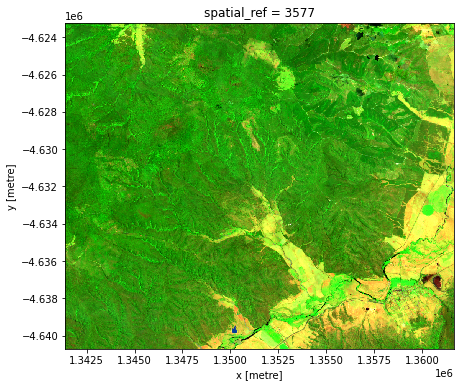

In [12]:
rgb(ds_before,  bands=['nbart_swir_3', 'nbart_nir_1', 'nbart_green'])

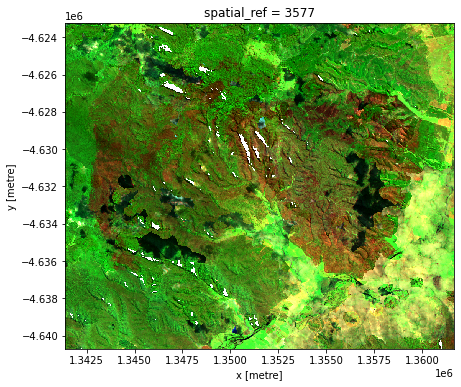

In [16]:
rgb(ds_after, bands=['nbart_swir_3', 'nbart_nir_1', 'nbart_green'])

# Calculate NBR and delta NBR
We can use the composites to calculate various indices, such as the Normalise Burn Ratio

In [17]:
# Compute NBR for the before image
ds_before_image = calculate_indices(ds_before,
                              index='NBR',
                              collection='ga_s2_1',
                              drop=False)

# Compute NBR for the after image
ds_after_image = calculate_indices(ds_after,
                              index='NBR',
                              collection='ga_s2_1',
                              drop=False)

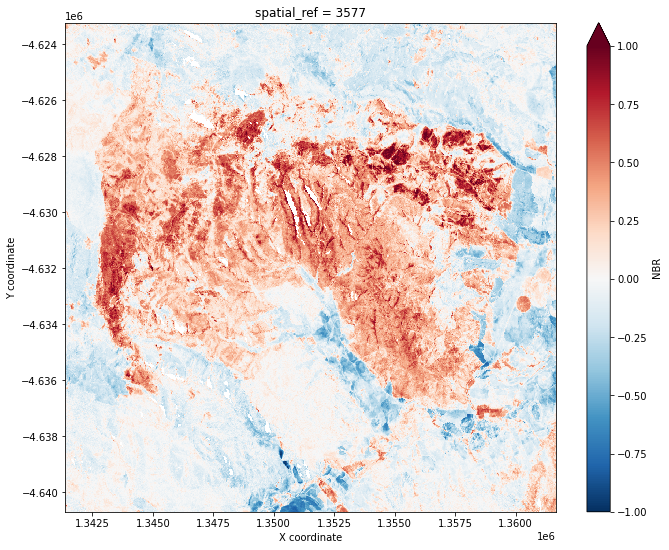

In [18]:
delta_NBR = ds_before_image.NBR - ds_after_image.NBR

# Visualise dNBR image
delta_NBR.plot(cmap='RdBu_r', vmin=-1, vmax=1, figsize=(11, 9))
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate');

## Nearest time composite¶
Sometimes we just want the closest available data to a particular point in time. This composite will take values from before or after the specified time to find the nearest observation to our target time:

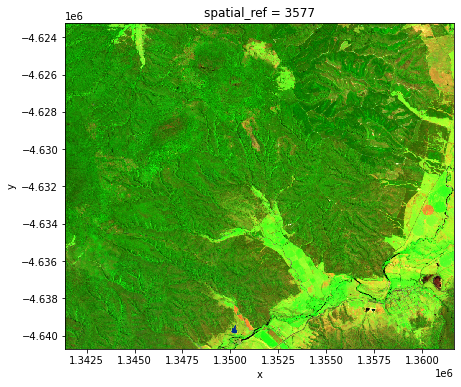

In [20]:
# Generate nearest time composite
da_nearest = nearest(da, dim='time', target='2019-11-01')

# Plot nearest time composite
ds_nearest = da_nearest.to_dataset(dim='variable').drop_dims('variable')
rgb(ds_nearest, bands=['nbart_swir_3', 'nbart_nir_1', 'nbart_green'])

By looking at the time for each pixel, we can see if the pixel was taken from before or after the target time.

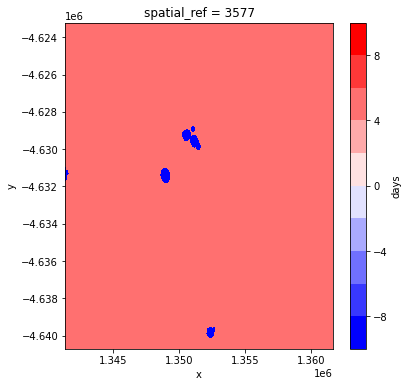

In [ ]:
target_datetime = da_nearest.time.dtype.type('2019-11-01')

# Calculate different in times and convert to number of days
num_days_different = (da_nearest.time.min(dim='variable') - target_datetime).dt.days

# Plot days before or after target date
num_days_different.plot(cmap='bwr', levels=11, figsize=(6, 6));

Export the results to GeoTiff

In [29]:
# Define an area name to be used in saved file names
area_name = 'Example'

# for COG we need an array not a dataset
before_da = ds_before_image.to_array() #baseline_image.drop('NBR').to_array()
after_da = ds_after_image.to_array()

# Write baseline reference image to multi-band GeoTIFF
cog.write_cog(before_da, f'{area_name}_before_image.tif', overwrite=True)

# Write post fire image to multi-band GeoTIFF
cog.write_cog(after_da, f'{area_name}_after_image.tif', overwrite=True)

# Delta NBR already Xarray Dataset - export to GeoTIFF
cog.write_cog(delta_NBR, f'{area_name}_delta_NBR.tif', overwrite=True)

PosixPath('Example_delta_NBR.tif')